In [1]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, SFD
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject6/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject6/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject6/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject6/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject6/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject6/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [2]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated


### z-normalization

In [3]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [4]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [5]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

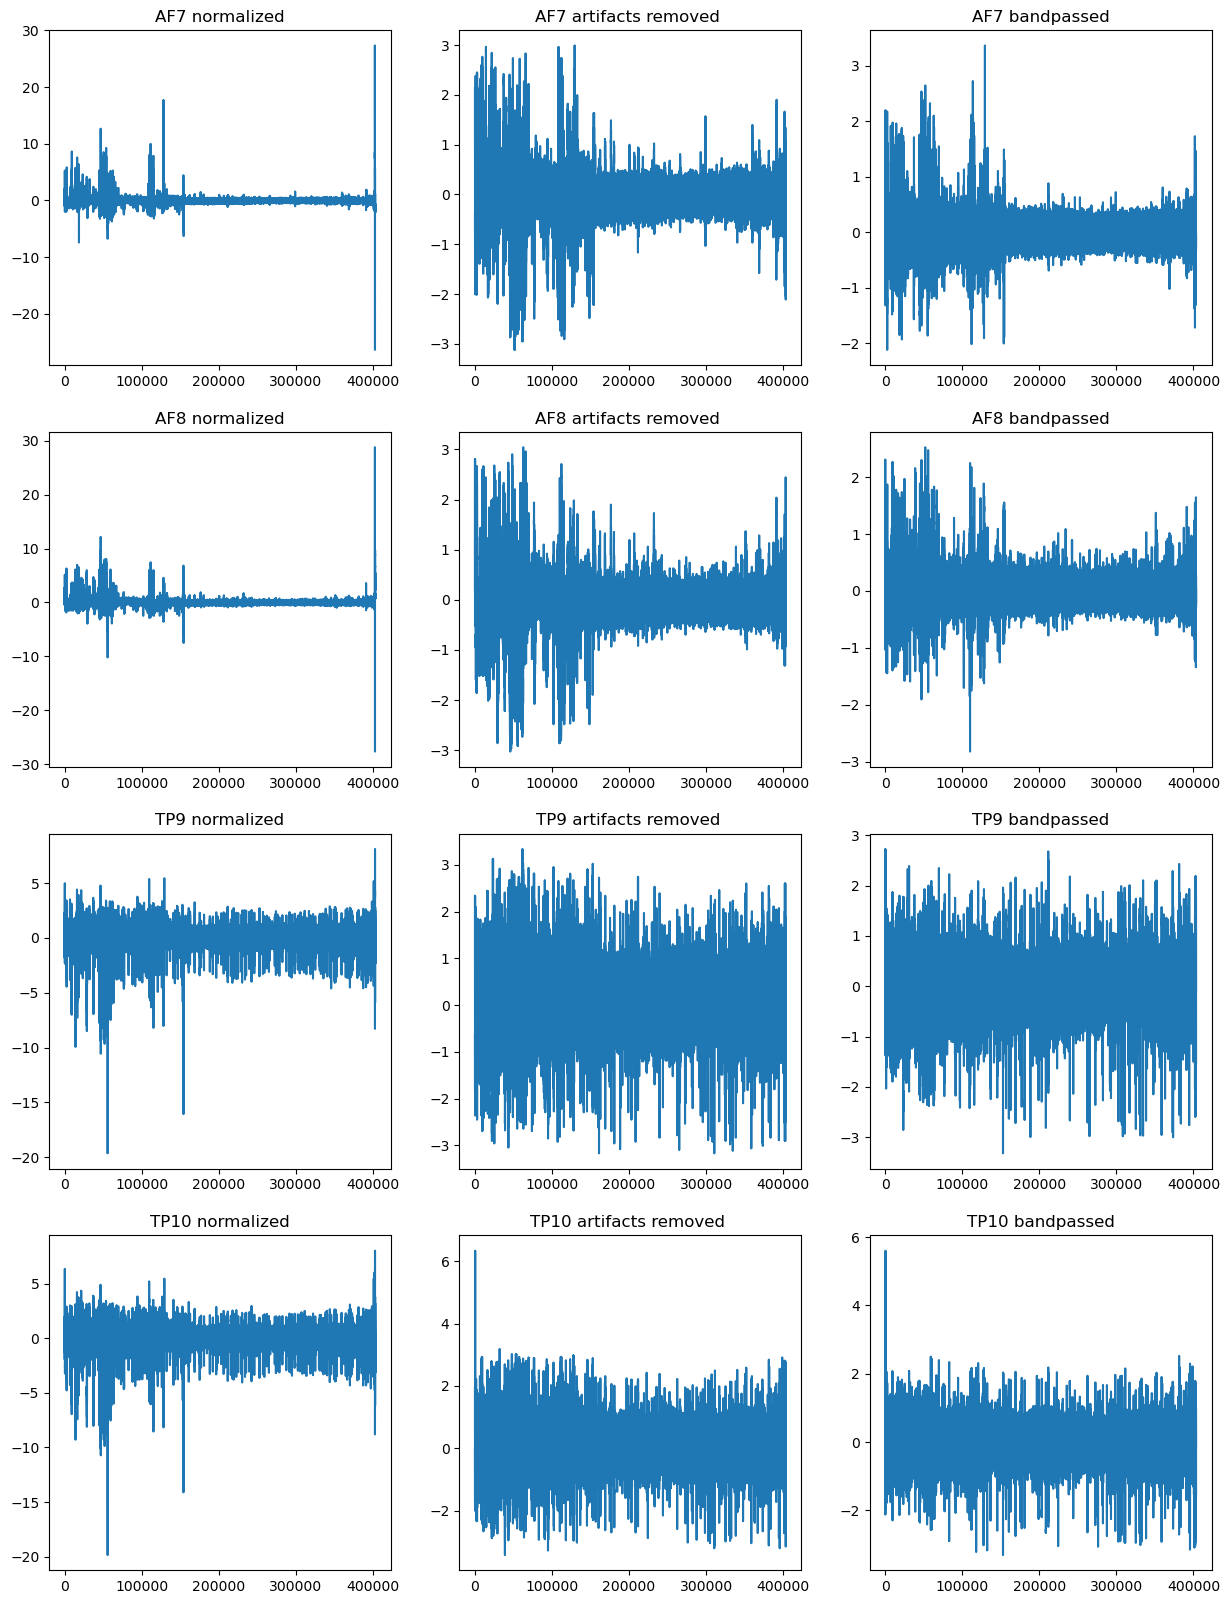

In [6]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [7]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

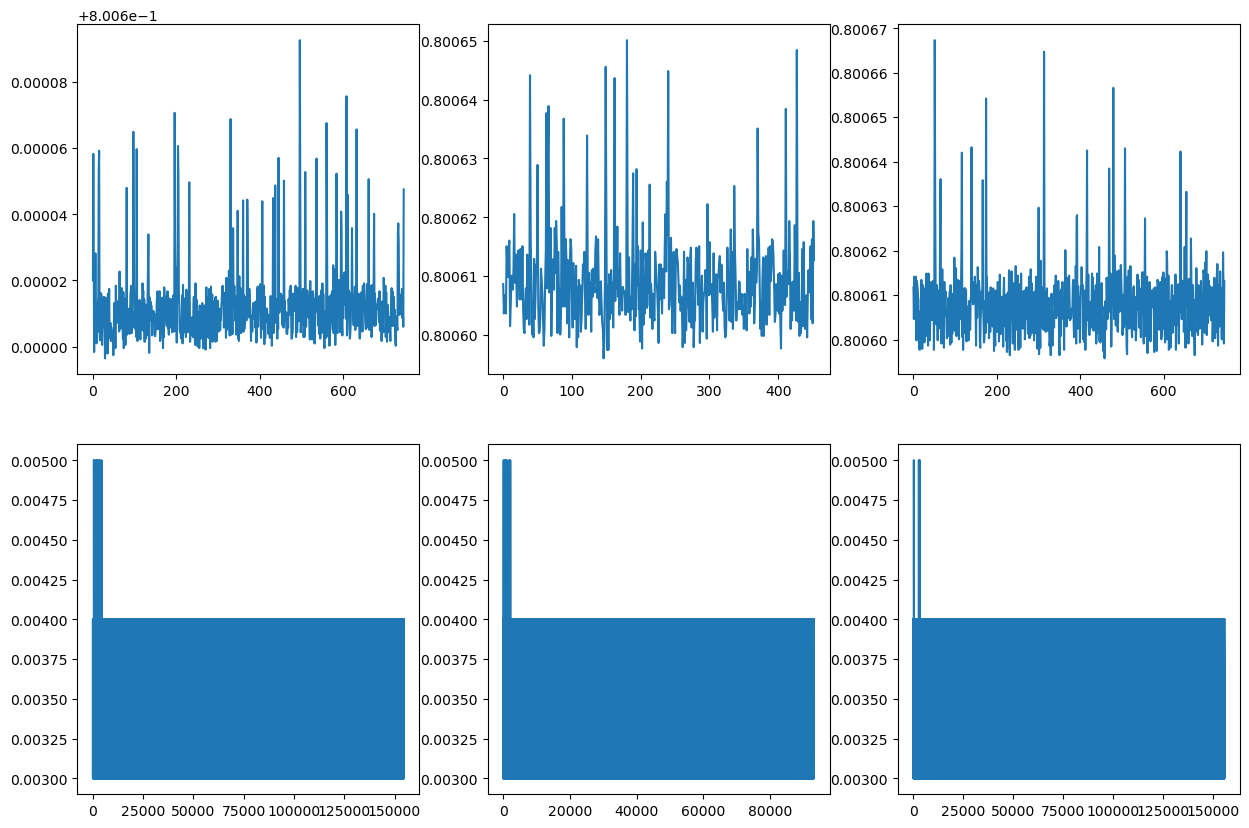

In [8]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

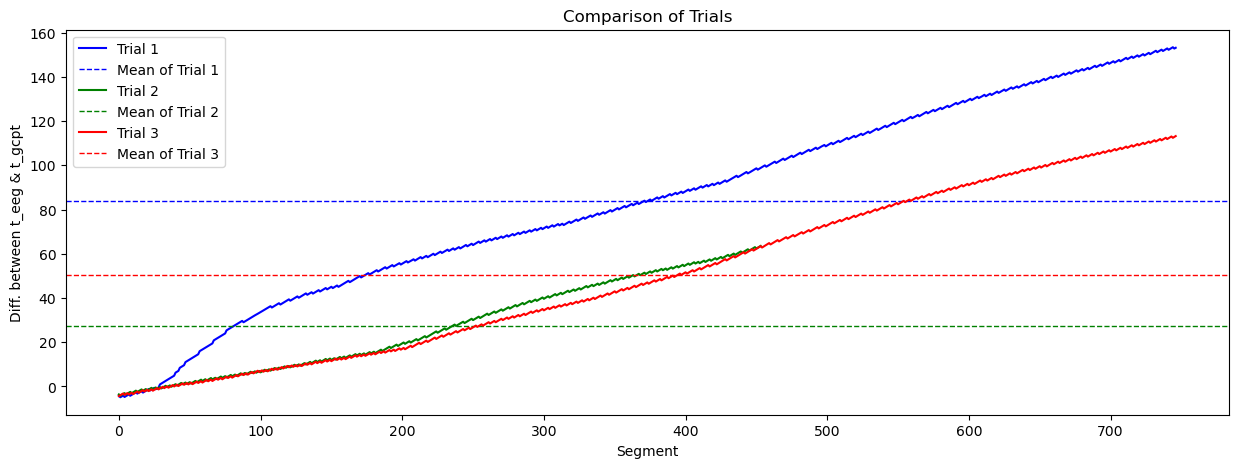

In [9]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Extract features

In [10]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [11]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

## Sequential feature detachment
### Combined channels

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 69.67%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 36.00
Train Accuraccy Detach Model: 75.41%
-------------------------
Test Accuraccy Full Model: 57.68%
Test Accuraccy Detach Model: 56.66%


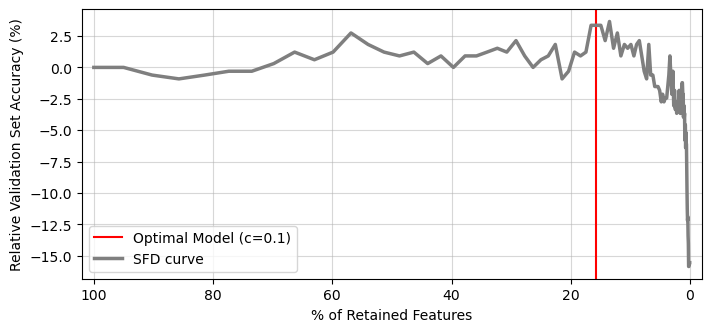

Optimal Model Size: 15.77% of full model
Number of features kept: 365


In [19]:
X_combined = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]

selected_features_all_channels = SFD(X_combined, y);
print(f'Number of features kept: {len(selected_features_all_channels.columns)-1}')

### AF7

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 61.63%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 6.00
Train Accuraccy Detach Model: 70.15%
-------------------------
Test Accuraccy Full Model: 62.80%
Test Accuraccy Detach Model: 52.22%


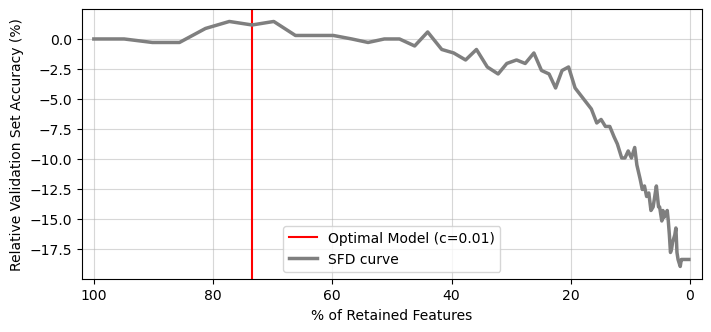

Optimal Model Size: 73.45% of full model
Number of features kept: 425


In [27]:
X_af7 = X_combined.filter(regex='^AF7.*')

selected_features_af7 = SFD(X_af7, y, 0.01)
print(f'Number of features kept: {len(selected_features_af7.columns)-1}')

### Train the model

In [44]:
n_features = len(selected_features_df.columns)-1 # last col is the label
for feats in [5, 15, 20, 25, n_features]:
    print(f'---{feats} FEATURES---')
    train(runs=5, num_features=feats, df=selected_features_df)

---5 FEATURES---
Avg: 55.52%
---15 FEATURES---
Avg: 55.94%
---20 FEATURES---
Avg: 55.38%
---25 FEATURES---
Avg: 56.24%
---523 FEATURES---
Avg: 63.98%


### See feature importance